In [4]:
# Linear Regression model
import sys
import os
sys.path.append(os.path.abspath('..')) # adding path for packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import utils.data_preprocessing as dp
import numpy as np

In [5]:
data_X = dp.loadMatFile('../../Datasets/20110607S2_EEGandECoG_Su_Oosugi_ECoG128-EEG18/20110607S2_EEGECoG_Su_Oosugi_ECoG128-EEG18_mat/ECoG05_anesthesia.mat')
data_y = dp.loadMatFile('../../Datasets/20110607S2_EEGandECoG_Su_Oosugi_ECoG128-EEG18/20110607S2_EEGECoG_Su_Oosugi_ECoG128-EEG18_mat/EEG05_anesthesia.mat')
X = data_X[1]
y = data_y[1]

In [6]:
# downsample if mismatch in size of datasets
if data_X[1].shape[1] != data_y[1].shape[1]:
    # gaussian normalization
    if X.shape[1] > y.shape[1]:
        X = dp.downsample_data(X, y.shape[1])
    elif X.shape[1] < y.shape[1]:
        y = dp.downsample_data(y, X.shape[1])

(323262,)
(19, 323262)


In [7]:
X = X.T
y = y.T

# Split data into training, validation and test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Normalize X
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

print("Train shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32)

Train shapes: (255387, 129) (255387, 19)
Validation shapes: (31923, 129) (31923, 19)
Test shapes: (31924, 129) (31924, 19)


In [8]:
# simple linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

In [19]:
# instantiate the model
input_size = X_tensor.size(1)  # 129 (ecog)
output_size = y_tensor.size(1)  # 19 (eeg)
model = LinearRegressionModel(input_size, output_size)

# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# create DataLoader for batch processing
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64)

In [10]:
# 4-fold cross-validation
k = 4
loss_dict = {}
mse_dict = {}
for i in range(k):
    X_train_new = np.vstack((X_train[:i*X_train.shape[0]//k,:],X_train[(i+1)*X_train.shape[0]//k:,:]))
    X_val = X_train[i*X_train.shape[0]//k:(i+1)*X_train.shape[0]//k,:]
    y_train_new = np.vstack((y_train[:i*y_train.shape[0]//k,:],y_train[(i+1)*y_train.shape[0]//k:,:]))
    y_val = y_train[i*y_train.shape[0]//k:(i+1)*y_train.shape[0]//k,:]

    # possible hyperparameters
    low_bound = 0.5
    high_bound = 45
    sampling_rate = 1000
    X_train_filtered = dp.butter_bandpass_filter(X_train_new.T, low_bound, high_bound, sampling_rate)
    X_val_filtered = dp.butter_bandpass_filter(X_val.T, low_bound, high_bound, sampling_rate)

    # PCA whitening
    X_train_w = dp.whitening(X_train_filtered.T)
    X_val_w = dp.whitening(X_val_filtered.T)

    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_w, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_new, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_w, type=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    # Instantiate the model
    input_size = X_tensor.size(1)   # 129
    output_size = y_tensor.size(1)  # 19
    model = LinearRegressionModel(input_size, output_size)

    # Define loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9,0.99))
    
    num_epochs = 100
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, labels in dataloader:
            
            model.fit(X_train_tensor, y_train_tensor)
            y_pred = model.predict(X_val_tensor)
            loss_fn(y_val_tensor, y_pred)
        
            # Calculate MSE
            mse = torch.mean((outputs - labels) ** 2)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * inputs.size(0)
            epoch_mse += mse.item() * inputs.size(0)

        # Calculate average loss and mse for the epoch
        epoch_loss /= len(dataloader.dataset)
        epoch_mse /= len(dataloader.dataset)

        # Append the loss values to the lists
        loss_values.append(epoch_loss)
        mse_values.append(epoch_mse)

        # Print progress
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    

[1.85794154e+00 1.49482069e+00 8.52825364e-01 7.54656788e-01
 5.73245062e-01 4.70720280e-01 3.55196523e-01 3.42335779e-01
 2.62892905e-01 2.44331328e-01 2.34878571e-01 2.14263019e-01
 1.74024782e-01 1.67375063e-01 1.49509035e-01 1.40650340e-01
 1.32354990e-01 1.29873354e-01 1.20672364e-01 1.08334367e-01
 1.06231529e-01 1.00173826e-01 9.53450552e-02 9.29467260e-02
 8.97313366e-02 8.14984592e-02 8.07640020e-02 7.70245451e-02
 7.58288519e-02 7.39116229e-02 7.00520757e-02 6.92854367e-02
 6.38946133e-02 6.38061523e-02 6.09608199e-02 5.86791763e-02
 5.68572345e-02 5.44347170e-02 5.15317341e-02 5.05391908e-02
 4.98456335e-02 4.88073270e-02 4.52848976e-02 4.32365295e-02
 4.19472070e-02 4.01826707e-02 3.94270769e-02 3.91041643e-02
 3.70245262e-02 3.62702255e-02 3.54293317e-02 3.42935623e-02
 3.34319803e-02 3.24081970e-02 3.02979285e-02 2.99448575e-02
 2.93468201e-02 2.91338171e-02 2.78167007e-02 2.71104419e-02
 2.63186846e-02 2.57069508e-02 2.43288380e-02 2.37705999e-02
 2.28287464e-02 2.258216

TypeError: tensor() got an unexpected keyword argument 'type'

In [20]:
# Training loop RAW DATA
num_epochs = 200
loss_values = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for inputs, labels in dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Calculate average loss and mse for the epoch
    epoch_loss /= len(dataloader)

    # Append the loss values to the lists
    loss_values.append(epoch_loss)

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [10/200], Loss: 99689.7941
Epoch [20/200], Loss: 28335.2712
Epoch [30/200], Loss: 28319.2760
Epoch [40/200], Loss: 28319.2694
Epoch [50/200], Loss: 28319.2696
Epoch [60/200], Loss: 28319.2696
Epoch [70/200], Loss: 28319.2696
Epoch [80/200], Loss: 28319.2696
Epoch [90/200], Loss: 28319.2696
Epoch [100/200], Loss: 28319.2696
Epoch [110/200], Loss: 28319.2696
Epoch [120/200], Loss: 28319.2696
Epoch [130/200], Loss: 28319.2696
Epoch [140/200], Loss: 28319.2696
Epoch [150/200], Loss: 28319.2696
Epoch [160/200], Loss: 28319.2696
Epoch [170/200], Loss: 28319.2696
Epoch [180/200], Loss: 28319.2696
Epoch [190/200], Loss: 28319.2696
Epoch [200/200], Loss: 28319.2696


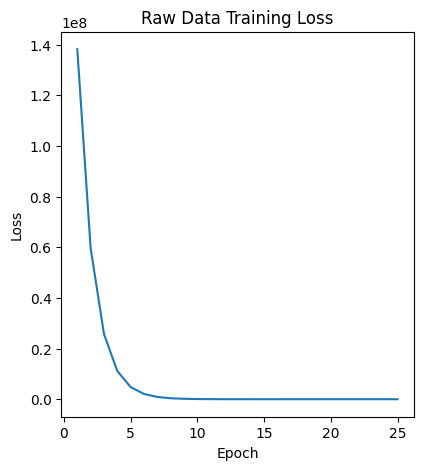

In [15]:
# Plot loss function
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 25 + 1), loss_values[:25], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Raw Data Training Loss')
plt.show()

In [ ]:
# Evaluate on validation set
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Make predictions on validation set
model.eval()
with torch.no_grad():
    y_pred = model(X_val_tensor)
    val_loss = criterion(y_pred, y_val_tensor).item()
    
    y_pred_np = y_pred.numpy().T
    y_val_np = y_val_tensor.numpy().T
    
    corc = np.corrcoef(y_pred_np, y_val_np)
    corc = (corc + 1) / 2
    # average across rows
    electrode_corc = np.mean(corc, axis=1)
    print("accuracy per electrode: ")
    print(electrode_corc)
    overall_acc = np.mean(corc)
    
print(f"Test Error: \n Accuracy: {overall_acc:>0.2f}%, Avg loss: {val_loss:>8f} \n")

accuracy per electrode: 
[0.56610452 0.61824975 0.56554917 0.53550618 0.62631021 0.63681099
 0.62563633 0.47032548 0.66130273 0.62038294 0.52629525 0.64592753
 0.64359139 0.66813242 0.66724034 0.66638385 0.62983261 0.66346822
 0.48595351 0.61553754 0.67017019 0.63249002 0.54699118 0.67429994
 0.67655835 0.67468985 0.42853108 0.68066014 0.64544326 0.39939223
 0.67538264 0.67292322 0.68159221 0.68369986 0.68459216 0.67309604
 0.68043738 0.51217702]
Test Error: 
 Accuracy: 0.62%, Avg loss: 26915.943359 



In [11]:
# instantiate the model
input_size = X_tensor.size(1)  # 129 (ecog)
output_size = y_tensor.size(1)  # 19 (eeg)
preprocess_model = LinearRegressionModel(input_size, output_size)

# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [12]:
# possible hyperparameters
low_bound = 0.5
high_bound = 45
sampling_rate = 1000

# bandwidth_butterworth_filter
X_train_filtered = dp.butter_bandpass_filter(X_train.T, low_bound, high_bound, sampling_rate)
X_val_filtered = dp.butter_bandpass_filter(X_val.T, low_bound, high_bound, sampling_rate)

# PCA whitening
X_train_w = dp.whitening(X_train_filtered.T)
X_val_w = dp.whitening(X_val_filtered.T)

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X_train_w.T, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32)

print(X_tensor.size(1))
print(y_tensor.size(1))
# create DataLoader for batch processing
processed_dataset = TensorDataset(X_tensor, y_tensor)
processed_dataloader = DataLoader(dataset, batch_size=64)



[1.86146425e+00 1.48805894e+00 8.55038207e-01 7.54821975e-01
 5.76618557e-01 4.68704650e-01 3.53831111e-01 3.43480154e-01
 2.66629897e-01 2.43436032e-01 2.34607661e-01 2.12606993e-01
 1.72947829e-01 1.65800316e-01 1.51145903e-01 1.40155384e-01
 1.31290943e-01 1.29340745e-01 1.20017247e-01 1.08223710e-01
 1.05525330e-01 1.00105768e-01 9.54325438e-02 9.34782753e-02
 8.93953772e-02 8.13305308e-02 8.06822454e-02 7.68215943e-02
 7.52735288e-02 7.39073841e-02 7.08011257e-02 6.89932181e-02
 6.41884242e-02 6.35894897e-02 6.10612282e-02 5.89204426e-02
 5.72771214e-02 5.40504434e-02 5.17509966e-02 5.09175771e-02
 4.97831784e-02 4.86533207e-02 4.53524072e-02 4.30934209e-02
 4.22312135e-02 3.99268728e-02 3.94956285e-02 3.90444966e-02
 3.68654350e-02 3.62211195e-02 3.54523214e-02 3.42847917e-02
 3.35847955e-02 3.24268962e-02 3.04609405e-02 3.01276316e-02
 2.93436942e-02 2.91787744e-02 2.80510217e-02 2.72922756e-02
 2.64556983e-02 2.58788538e-02 2.45647941e-02 2.38382452e-02
 2.28712743e-02 2.260994

In [13]:
# Training loop PREPROCESSED DATA
num_epochs = 200
loss_values = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for inputs, labels in processed_dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Calculate average loss and mse for the epoch
    epoch_loss /= len(processed_dataloader)

    # Append the loss values to the lists
    loss_values.append(epoch_loss)

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [10/200], Loss: 99318.1226
Epoch [20/200], Loss: 27420.9291
Epoch [30/200], Loss: 27345.1181
Epoch [40/200], Loss: 27311.8643
Epoch [50/200], Loss: 27290.5057
Epoch [60/200], Loss: 27275.4894
Epoch [70/200], Loss: 27264.2584
Epoch [80/200], Loss: 27255.4747
Epoch [90/200], Loss: 27248.3674
Epoch [100/200], Loss: 27242.4659
Epoch [110/200], Loss: 27237.4628
Epoch [120/200], Loss: 27233.1497
Epoch [130/200], Loss: 27229.3822
Epoch [140/200], Loss: 27226.0544
Epoch [150/200], Loss: 27223.0888
Epoch [160/200], Loss: 27220.4244
Epoch [170/200], Loss: 27218.0162
Epoch [180/200], Loss: 27215.8278
Epoch [190/200], Loss: 27213.8298
Epoch [200/200], Loss: 27211.9986


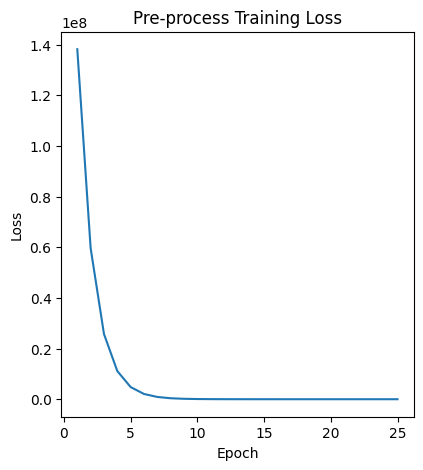

In [14]:
# Plot loss function
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 25 + 1), loss_values[:25], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pre-process Training Loss')
plt.show()

In [21]:
# Evaluate on validation set
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Make predictions on validation set
model.eval()
with torch.no_grad():
    y_pred = model(X_val_tensor)
    val_loss = criterion(y_pred, y_val_tensor).item()
    
    y_pred_np = y_pred.numpy().T
    y_val_np = y_val_tensor.numpy().T
    
    corc = np.corrcoef(y_pred_np, y_val_np)
    corc = (corc + 1) / 2
    # average across rows
    electrode_corc = np.mean(corc, axis=1)
    print("accuracy per electrode: ")
    print(electrode_corc)
    overall_acc = np.mean(corc)
    
print(f"Test Error: \n Accuracy: {overall_acc:>0.4f}%, Avg loss: {val_loss:>8f} \n")

accuracy per electrode: 
[0.59821239 0.64762219 0.61734214 0.57280512 0.64983227 0.64990679
 0.64537307 0.41887121 0.64334963 0.58250406 0.39660444 0.65128125
 0.64949378 0.65799558 0.65738152 0.65727894 0.6507965  0.65465697
 0.51653187 0.59764491 0.65269095 0.61955781 0.54132001 0.65496216
 0.65750945 0.65413003 0.43230688 0.65892695 0.60972831 0.3931737
 0.65496369 0.65300858 0.65914819 0.65909323 0.65889404 0.65476705
 0.6568584  0.51152749]
Test Error: 
 Accuracy: 0.6078%, Avg loss: 28152.369141 

